In [294]:
!pip install k-means-constrained

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 353.4/353.4 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 27.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 39.1 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.0/404.0 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 49.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3


In [3]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from collections import defaultdict
from k_means_constrained import KMeansConstrained

/Users/sebastianguo/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
# bring in Spotify API access token
CLIENT_ID = "122b00a742b444de9998b65664e0f628"
CLIENT_SECRET = "cb75988b96494d3c9341aeb8449ffe47"

AUTH_URL = 'https://accounts.spotify.com/api/token'
auth_response = requests.post(AUTH_URL, {
    'grant_type': 'client_credentials',
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET,
})

auth_response_data = auth_response.json()
access_token = auth_response_data['access_token']
headers = {
    'Authorization': 'Bearer {token}'.format(token=access_token)
}
BASE_URL = 'https://api.spotify.com/v1/'

In [5]:
PLAYLIST_IDS = {
    "liked_songs_id": "4C1EpavI1yqCw1MKG9ImQR?si=f7bc5b601d4d405b",
    "chip_chop_id": "7eAIoDwmfqgYdzqz5adjMw?si=c70314a39c9d44df",
    "hip_hop_id": "1GZ9eDb1ujSUug585ah40Q?si=54eb182afe9f4c6c",
    "couch_id": "5uxJwCYPWdFkD3H9gnG0PQ?si=a74e8d754abe4980",
    "pop_id": "1wkpuW6KINp6W84PBO0Q1n?si=81f8489d2bb9479e",
    "sad_id": "6eSIUzw1CIMVxmGriRh2Du?si=d318b817c9474cd2",
    "kpop_id": "7btk1xR1uMl3BJsDMUO7sk?si=49ac6f82971a4ff6",
    "gym_id": "5jMWW2Rt7Zf1BNdU9U7nLT?si=46fb645eaef64af3",
    "good_vibes_id": "0lxSRAAFgUk39dBCzuZiO6?si=53ad8b8c3c57402b",
    "electronic_id": "6EE3r1shbfcO1Ktkp07d2F?si=b39b54250ef0483b",
    "indie_lovecore_id": "0VtpIhMmVqiUOaLpDAOt1X?si=4e94b5e261924550",
    "euphoric_id": "0Komy1LCzHwkSbQ5LaSUIn?si=2d6ce99be64c4045"
}

In [9]:
# call API to get songs from playlist IDs
songs = []
for list_id in PLAYLIST_IDS:
    song_req = requests.get(BASE_URL + 'playlists/' + PLAYLIST_IDS[list_id], headers=headers).json()
    for item in song_req['tracks']['items']:
        song_info = item['track']
        song_features_req = requests.get(BASE_URL + 'audio-features/' + song_info['id'], headers=headers).json()

        song_dict = {"name": song_info['name']}
        song_dict.update(song_features_req)
        song_dict.update({"artists": [item['name'] for item in song_info['album']['artists']]})
        genres = set()
        for item in song_info['album']['artists']:
            artist_req = requests.get(BASE_URL + 'artists/' + item['id'], headers=headers).json()
            genres.update(set(artist_req['genres']))
        song_dict.update({"artists_genres": genres})
        songs.append(song_dict)


In [12]:
%store songs

Stored 'songs' (list)


In [1]:
%store -r songs
songs = list(filter(lambda x: len(x["name"]) > 0, songs))
songs[0:1]

[{'name': 'dangerous',
  'danceability': 0.755,
  'energy': 0.835,
  'key': 5,
  'loudness': -4.68,
  'mode': 0,
  'speechiness': 0.277,
  'acousticness': 0.0635,
  'instrumentalness': 0,
  'liveness': 0.151,
  'valence': 0.575,
  'tempo': 151.953,
  'type': 'audio_features',
  'id': '6LWpNGl9oKW2dFZbleaTao',
  'uri': 'spotify:track:6LWpNGl9oKW2dFZbleaTao',
  'track_href': 'https://api.spotify.com/v1/tracks/6LWpNGl9oKW2dFZbleaTao',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/6LWpNGl9oKW2dFZbleaTao',
  'duration_ms': 265305,
  'time_signature': 4,
  'artists': ['21 Savage', 'Lil Durk', 'Metro Boomin'],
  'artists_genres': {'atl hip hop',
   'chicago drill',
   'chicago rap',
   'drill',
   'hip hop',
   'rap',
   'trap'}}]

In [6]:
track_df = pd.DataFrame(data=songs)
track_df = track_df.drop(["type", "uri", "track_href"], axis=1)
track_df['index'] = np.arange(track_df.shape[0])
track_df.head()

,name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,analysis_url,duration_ms,time_signature,artists,artists_genres,index
0,dangerous,0.755,0.835,5,-4.680,0,0.2770,0.06350,0.000000,0.1510,0.575,151.953,6LWpNGl9oKW2dFZbleaTao,https://api.spotify.com/v1/audio-analysis/6LWp...,265305,4,"[21 Savage, Lil Durk, Metro Boomin]","{chicago drill, trap, drill, rap, hip hop, atl...",0
1,Mr. Right Now (feat. Drake),0.647,0.667,5,-5.563,1,0.3040,0.23100,0.000000,0.1330,0.704,172.080,4Q34FP1AT7GEl9oLgNtiWj,https://api.spotify.com/v1/audio-analysis/4Q34...,193839,4,"[21 Savage, Metro Boomin]","{hip hop, atl hip hop, rap}",1
2,Runnin,0.819,0.626,10,-4.574,0,0.2020,0.00748,0.101000,0.1670,0.415,143.010,5SWnsxjhdcEDc7LJjq9UHk,https://api.spotify.com/v1/audio-analysis/5SWn...,195906,4,"[21 Savage, Metro Boomin]","{hip hop, atl hip hop, rap}",2
3,Mood (feat. iann dior),0.701,0.716,7,-3.671,0,0.0361,0.17400,0.000000,0.3240,0.732,91.007,4jPy3l0RUwlUI9T5XHBW2m,https://api.spotify.com/v1/audio-analysis/4jPy...,140533,4,[24kGoldn],"{cali rap, pop rap}",3
4,"Midsummer Madness 20 (feat. Joji, Rich Brian, ...",0.726,0.789,9,-5.499,1,0.0468,0.49800,0.000001,0.0907,0.560,94.987,5qaDbDqAwvJZgn1I15Wk3L,https://api.spotify.com/v1/audio-analysis/5qaD...,246947,4,"[88rising, Danny Ocean]","{urbano latino, asian american hip hop, pop ve...",4


In [8]:
# Feature Selection Using Principal Feature Analysis 
track_df_copy = track_df.copy(deep=True)
col_to_norm = ["danceability", "energy", "loudness", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "key", "tempo", "duration_ms", "time_signature"]
track_features = track_df_copy[col_to_norm]
sc = StandardScaler()
num_features = sc.fit_transform(track_features)
print(num_features[0,:])
pca = PCA(n_components=num_features.shape[1]).fit(num_features)
pca_components = pca.components_.T
pca_components.shape

# cluster different features into n clusters
kmeans = KMeans(n_clusters=5, n_init='auto', random_state=4).fit(pca_components)
clusters = kmeans.predict(pca_components)
cluster_centers = kmeans.cluster_centers_
dists = defaultdict(list)

# iterate over PCA features to find, for each centroid, the closest PCA feature
for i, c in enumerate(clusters):
    dist = euclidean_distances([pca_components[i, :]], [cluster_centers[c, :]])[0][0]
    dists[c].append((i, dist))

indices = [sorted(f, key=lambda x: x[1])[0][0] for f in dists.values()]
features = [col_to_norm[f] for f in indices]
features

[ 0.53353692  1.20430689  0.80278731  1.39178215 -0.59092384 -0.21616307
 -0.25209445  0.2573004  -0.1101334   1.14827662  0.79653608  0.10334848]


['danceability', 'energy', 'speechiness', 'valence', 'liveness']

In [10]:
# track_df[features] = (track_df[features]-track_df[features].min())/ \
# (track_df[features].max()-track_df[features].min())
features = ["danceability", "energy", "speechiness", "liveness"]
features_X = sc.fit_transform(track_df[features])
X = pd.concat([track_df["name"], track_df["index"], pd.DataFrame(features_X)], axis=1)
to_rename = {i: sc.get_feature_names_out()[i] for i in range(len(sc.get_feature_names_out()))}
X = X.rename(columns=to_rename)

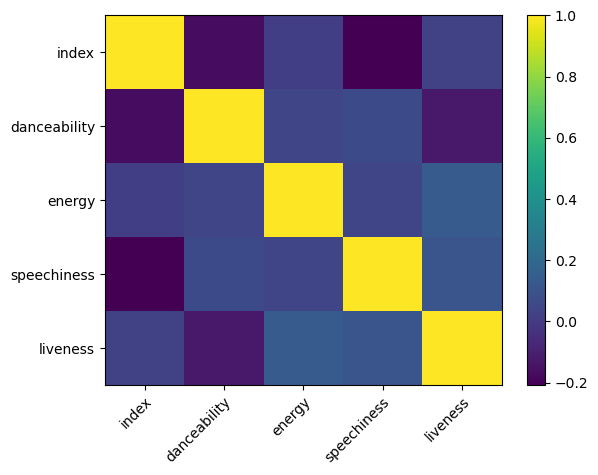

In [32]:
corr_mat = X.corr(numeric_only=True)

fig, ax = plt.subplots()
im = ax.imshow(corr_mat, aspect='auto')
plt.colorbar(im)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(corr_mat.shape[0]), labels=corr_mat.columns)
ax.set_yticks(np.arange(corr_mat.shape[1]), labels=corr_mat.columns)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

plt.show()

In [109]:
N_CLUSTERS = 3
kmeansc = KMeansConstrained(
    n_clusters=N_CLUSTERS,
    size_min=50,
    size_max=500,
    random_state=0
)
kmeansc.fit_predict(X[features])
labelled_data_c = pd.concat([X, pd.DataFrame({"labels": kmeansc.labels_})], axis=1)
labelled_data_c.sort_values("labels")

,name,index,danceability,energy,speechiness,liveness,labels
378,Don't Stop 'Til You Get Enough,378,1.381330,1.116905,-0.306030,-0.037194,0
450,Break My Heart,450,0.361221,0.542549,-0.311448,1.077601,0
449,We're Good,449,0.306080,-0.337714,-0.618500,-0.037194,0
448,Wicked Games,448,-0.135048,-0.300256,-0.829823,0.916426,0
447,In Your Eyes,447,-0.073015,0.480119,-0.797312,-0.771885,0
...,...,...,...,...,...,...,...
404,True Love,404,-1.520467,1.129391,1.698833,-0.540867,2
399,bad guy,399,0.161335,-1.355323,2.276812,-0.594592,2
65,Me and My Guitar,65,-0.231545,-0.343957,2.078132,-0.756439,2
613,Ride,613,0.306080,-0.312742,2.349059,-0.786659,2


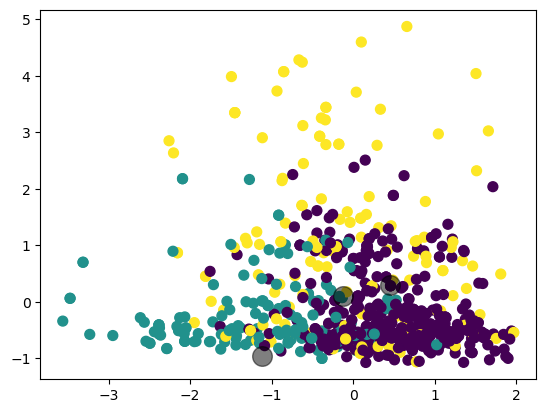

In [110]:
plt.scatter(X["danceability"], X["liveness"], c=kmeansc.labels_, s=50, cmap='viridis')

centers = kmeansc.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);


In [112]:
song_obj = {}
for cluster_i in range(N_CLUSTERS):
    song_obj[cluster_i] = list(labelled_data_c.loc[labelled_data_c["labels"] == cluster_i]["name"])

In [113]:
print([len(song_obj[i]) for i in song_obj])

[437, 158, 162]


In [114]:
song_obj[2]

['dangerous',
 'Mr. Right Now (feat. Drake)',
 'Caroline',
 'Spice Girl',
 'family ties (with Kendrick Lamar)',
 'first order of business',
 'range brothers (with Kendrick Lamar)',
 'STATS',
 'trademark usa',
 'Después de la Playa',
 'Tití Me Preguntó',
 'ENERGY (feat. Beam)',
 'Irreplaceable',
 'Love On Top',
 "VIRGO'S GROOVE",
 'Beware',
 'Overtime',
 'Ice Cream (with Selena Gomez)',
 'Kill This Love',
 'Magic (feat. Rivers Cuomo)',
 'Me and My Guitar',
 "All We Got (feat. Kanye West & Chicago Children's Choir)",
 'Bonfire',
 '3005',
 'Wet Dreamz',
 'Best I Ever Had',
 'Bitch, Don’t Kill My Vibe',
 'Power Trip (feat. Miguel)',
 'Poetic Justice',
 'Love Is Only a Feeling',
 'Do Not Disturb',
 'Been Away',
 'Codeine Crazy',
 'MELTDOWN (feat. Drake)',
 'Flex',
 'The Race - Remix',
 "Let Em' Know",
 'November 18th',
 'Surround Sound (feat. 21 Savage & Baby Tate)',
 "Wat's Wrong (feat. Zacari & Kendrick Lamar)",
 "All We Got (feat. Kanye West & Chicago Children's Choir)",
 'DNA.',
 'Eleva

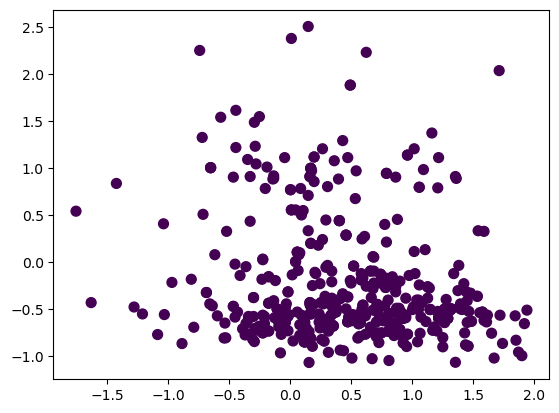

In [120]:
# # clusters 0 and 1 are super close to each other: merge them
song_clst = labelled_data_c.loc[(labelled_data_c["labels"] == 0)]
plt.scatter(song_clst["danceability"], song_clst["liveness"], c=song_clst["labels"], s=50, cmap='viridis')


In [116]:
# labelled_data_c["labels"] = labelled_data_c["labels"].replace(0, 1)
# plt.scatter(labelled_data_c["danceability"], labelled_data_c["liveness"], c=labelled_data_c["labels"], s=50, cmap='viridis')


In [121]:
%store labelled_data_c

Stored 'labelled_data_c' (DataFrame)


In [126]:
grouped = labelled_data_c.groupby(labelled_data_c.labels)
cluster_0, cluster_1, cluster_2 = grouped.get_group(0).reset_index(), grouped.get_group(1).reset_index(), grouped.get_group(2).reset_index()
cluster_1

,level_0,name,index,danceability,energy,speechiness,liveness,labels
0,10,If I Ain't Got You,10,-0.472787,-1.236706,-0.152504,-0.567729,1
1,11,No One,11,-0.231545,-0.581191,-0.852400,-0.366260,1
2,14,REEL IT IN,14,0.526644,-1.873492,-0.214818,0.029962,1
3,17,Love Me Harder,17,-1.320581,0.436418,-0.813567,-0.753081,1
4,20,Save Myself,20,-0.900130,-0.599920,-0.784668,0.862701,1
...,...,...,...,...,...,...,...,...
153,746,Chandelier,746,-2.375153,-0.899584,-0.687135,-0.460279,1
154,750,One More Hour,750,-0.210867,-1.523884,-0.854206,-0.272241,1
155,752,SUGAR,752,-1.548037,-0.649864,-0.533609,0.009815,1
156,753,SLOW DANCING IN THE DARK,753,-1.106909,-1.018201,-0.874074,0.016531,1


In [132]:
N_CLUSTERS_INNER = 4
kmeansc_inner = KMeansConstrained(
    n_clusters=N_CLUSTERS_INNER,
    size_min=40,
    size_max=150,
    random_state=0
)
kmeansc_inner.fit_predict(cluster_0[features])
cluster_0["labels_inner"] = kmeansc_inner.labels_
cluster_0["labels_inner"].value_counts()

labels_inner
0    150
2    133
1     78
3     76
Name: count, dtype: int64

In [154]:
cluster_0 = cluster_0.drop('level_0', axis=1)
grouped_cluster_0 = cluster_0.groupby(cluster_0.labels_inner)
cluster_3, cluster_4, cluster_5, cluster_6 = grouped_cluster_0.get_group(0).reset_index(), grouped_cluster_0.get_group(1).reset_index(), grouped_cluster_0.get_group(2).reset_index(), grouped_cluster_0.get_group(3).reset_index()

In [164]:
playlists_kmeans = [cluster_1, cluster_2, cluster_3, cluster_4, cluster_5, cluster_6]

In [38]:
discover_playlist="37i9dQZEVXcON7akWEgBtp?si=cd0bd7db730f4428"

In [ ]:
# Gaussian Mixture Model Algorithm